In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Preparing the Data

In [15]:
df = pd.read_csv("Cancer_Data.csv")
df.drop(columns=['id', 'Unnamed: 32'], inplace=True)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

### Normalization

In [16]:
X = df.drop(columns=['diagnosis']).values
y = df['diagnosis'].values.reshape(-1, 1)
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
pd.x_normal = pd.DataFrame(X_normalized, columns=df.columns[:-1])
pd.x_normal.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


### Train-Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42, stratify=y
)

### Initialize weights and bias

In [18]:
def initialize_weights(n_features):
    return np.zeros((n_features, 1)), 0


### Sigmoid Function

In [19]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Forward and Backward Propagation

In [20]:
def propagate_regularized(w, b, X, y, lambda_):
    m = X.shape[0]
    z = np.dot(X, w) + b
    y_hat = sigmoid(z)
    base_loss = - (1 / m) * np.sum(y * np.log(y_hat + 1e-8) + (1 - y) * np.log(1 - y_hat + 1e-8))
    l2_penalty = (lambda_ / (2 * m)) * np.sum(np.square(w))
    loss = base_loss + l2_penalty
    dz = y_hat - y
    dw = (1 / m) * np.dot(X.T, dz) + (lambda_ / m) * w
    db = (1 / m) * np.sum(dz)
    grads = {"dw": dw, "db": db}
    return grads, loss

In [21]:
# Update weights and bias
def update_parameters(w, b, grads, learning_rate):
    w -= learning_rate * grads["dw"]
    b -= learning_rate * grads["db"]
    return w, b

### Training Function

In [26]:
def train_logistic_regression_regularized(X, y, w, b, learning_rate=0.1, num_iterations=1000, lambda_=0.1, print_cost=False):
    for i in range(num_iterations):
        grads, cost = propagate_regularized(w, b, X, y, lambda_)
        w, b = update_parameters(w, b, grads, learning_rate)
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost:.4f}")
    return {"w": w, "b": b}



### Prediction Function

In [27]:
def predict(w, b, X):
    y_hat = sigmoid(np.dot(X, w) + b)
    return (y_hat >= 0.5).astype(int)


### Cross-Validation Evaluation

In [28]:
def cross_validate(X, y, lambda_=0.1, learning_rate=0.1, num_iterations=1000, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    acc_scores = []
    recall_scores = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index].reshape(-1, 1), y[val_index].reshape(-1, 1)
        w, b = initialize_weights(X.shape[1])
        params = train_logistic_regression_regularized(X_train_fold, y_train_fold, w, b,
                                                       learning_rate, num_iterations, lambda_)
        y_val_pred = predict(params["w"], params["b"], X_val_fold)
        acc_scores.append(accuracy_score(y_val_fold, y_val_pred))
        recall_scores.append(recall_score(y_val_fold, y_val_pred))

    print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average Recall: {np.mean(recall_scores):.4f}")


### Final Training and Evaluation on Test Set

In [29]:
w, b = initialize_weights(X_train.shape[1])
params = train_logistic_regression_regularized(X_train, y_train, w, b,
                                               learning_rate=0.1, num_iterations=1000, lambda_=0.1)

y_pred_train = predict(params["w"], params["b"], X_train)
y_pred_test = predict(params["w"], params["b"], X_test)

print("Training Evaluation")
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print("\nTest Evaluation")
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))


Training Evaluation
[[282   3]
 [ 21 149]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       285
           1       0.98      0.88      0.93       170

    accuracy                           0.95       455
   macro avg       0.96      0.93      0.94       455
weighted avg       0.95      0.95      0.95       455


Test Evaluation
[[72  0]
 [ 7 35]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        72
           1       1.00      0.83      0.91        42

    accuracy                           0.94       114
   macro avg       0.96      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114



This logistic regression model achieved a test accuracy of 94% and a malignant tumor recall of 83%. Precision on malignant cases reached 100%, eliminating false positives. These results demonstrate a strong balance between sensitivity and specificity, validating the model as a robust tool for breast cancer prediction. Regularization notably enhanced generalization performance without compromising recall, making the model more suitable for real-world clinical scenarios.

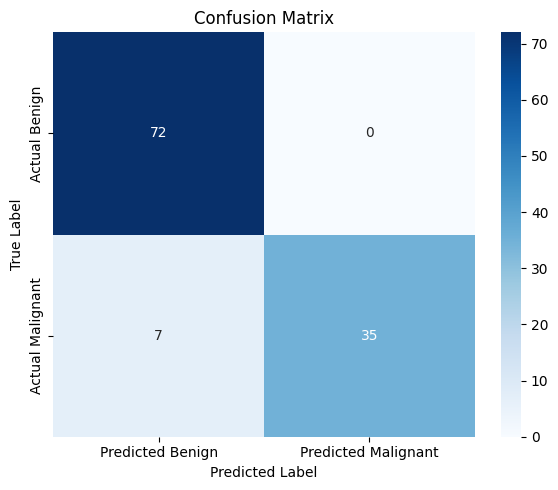

In [ ]:
# Plot confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Benign', 'Predicted Malignant'],
                yticklabels=['Actual Benign', 'Actual Malignant'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Generate plots for test set
plot_confusion_matrix(y_test, y_pred_test)

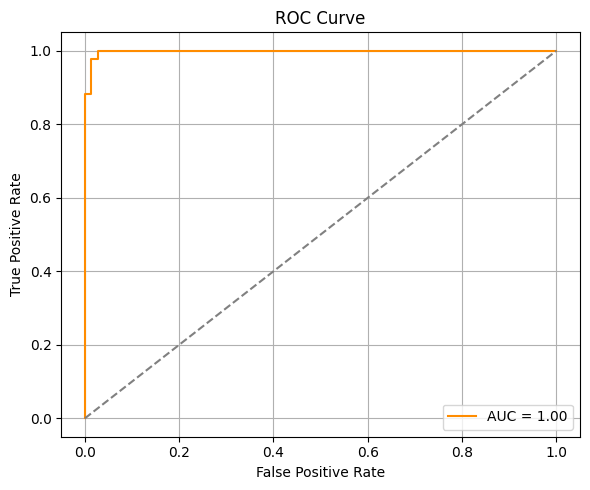

In [32]:
# Plot ROC curve
def plot_roc_curve(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# For ROC curve, we need probabilities (sigmoid output)
y_scores_test = sigmoid(np.dot(X_test, params["w"]) + params["b"])
plot_roc_curve(y_test, y_scores_test)